# Многоклассовая классификация

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

Загрузим датасет $MNIST$ и попробуем обучить на нем линейный классификатор. Но теперь будем домножать не на вектор, а на матрицу размера $785 \times 10$, получая на выходе вектор размера $10$. Далее применим к этому $softmax$, получив вектор вероятностей для различных классов. Будем использовать следующую архитектуру:
$$X_{1 \times 785} \xrightarrow{W_{785 \times 10}} \begin{pmatrix} out_1 & \cdots & out_{10} \end{pmatrix} \xrightarrow{softmax} \begin{pmatrix} p_1 & \cdots & p_{10} \end{pmatrix}$$
Функцию ошибки возьмем следующую:
$$Q(W) = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \log(p_i(W)).$$

Перепишем ее для в другом виде для одного элемента ($y$ - истинная мерка):
$$Q(W) = \log\frac{e^{out_y}}{\sum\limits_i e^{out_i}} = -out_y + \log\sum\limits_i e^{out_i}.$$

Запишем в матричном виде ($Y$ - истинный вектор (т.е. вектор из $0$ с единицей на месте $y$), умножение покоординатное):
$$Q(W) = -\sum(Y \cdot W) + \log\left(\sum e^{out}\right)$$
Для батча получаем ту же формулу. Теперь попробуем посчитать градиент для одного элемента:

$$\frac{\partial Q}{\partial W_{i,j}} = \frac{\partial}{\partial W_{i,j}}(-out_y) + \frac{\partial}{\partial W_{i,j}}\log(\sum e^{out}) = -x_i[j = y] + \frac{1}{\sum e_{out}}\frac{\partial}{\partial W_{i,j}} e^{out_j} = -x_i[j = y] + \frac{1}{\sum e_{out}}x_ie_j.$$

Запишем это в матричном виде ($\times$ - матричное умножение):
$$\frac{\partial Q}{\partial W} = -X^T \times Y + X^T \times P$$

In [12]:
data = pd.read_csv('train.csv', sep=',').values
data_division = 0.75

X_train = data[: round(data.shape[0] * data_division), 1 :] / 255
Labels_train = data[: round(data.shape[0] * data_division), 0 : 1]
Y_train = np.zeros((X_train.shape[0], 10))
for i in range(Y_train.shape[0]):
    Y_train[i, Labels_train[i]] = 1

X_val = data[round(data.shape[0] * data_division) :, 1 :] / 255
Y_val = data[round(data.shape[0] * data_division) :, 0 : 1]

Создадим класс линейного классификатора со следующими функциями
1. $\_\_forward$ - вычисление слоев $out, p$ для переданного батча
2. $\_\_step$ - шаг стохастического градиентного спуска на переданном батче
3. $fit$ - обучение на переданной выборке
4. $predict$ - предсказание меток на переданной выборке
5. $\_\_loss$ - вычисление функции ошибки на переданном батче
6. $\_\_gradient$ - вычисление градиента функции ошибки на переданном батче

In [13]:
class LinerarMulticlassClassification(object):
    def __init__(self, alpha=1E-5):
        self.alpha = alpha
    
    def __forward(self, X):
        self.out = X @ self.W
        self.probability = np.e ** self.out
        self.probability /= np.repeat(np.expand_dims(np.sum(self.probability, axis=1), axis=1), 10, axis=1)
    
    def __step(self, X, Y):
        self.__forward(X)
                
        current_loss = self.__loss(X, Y)
        gradient = self.__gradient(X, Y)
        
        self.W = self.W - self.alpha * gradient
        return current_loss
        
    def fit(self, X, Y, init='random', epoch=20, batch=1):
        if init == 'random':
            self.W = np.random.uniform(-1E-4, 1E-4, (X.shape[1] + 1, 10))
        elif init == 'zeros':
            self.W = np.zeros((X.shape[1] + 1, 10))
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Q = []
        current_epoch = 1
        while current_epoch <= epoch:
            print('Epoch: ', current_epoch, '/', epoch)
            common_loss = self.__loss(X, Y)
            print('Loss:', common_loss)
            
            for i in range(0, X.shape[0] // batch):
                loss = self.__step(X[batch * i : batch * (i + 1), :], Y[batch * i : batch * (i + 1), :])
                Q.append(loss)
            current_epoch += 1
        return Q
    
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        self.__forward(X)
        labels = np.argmax(self.probability, axis=1)
        return labels
    
    def __loss(self, X, Y):
        self.__forward(X)
        Q = np.sum((-np.sum(self.out * Y, axis=1) + np.log(np.sum(np.e ** self.out, axis=1)))) / X.shape[0]
        return Q
    
    def __gradient(self, X, Y):
        self.__forward(X)
        grad = -X.T @ Y + X.T @ self.probability
        return grad / X.shape[0]

Обучим полученный классификатор на датасете $MNIST$, поделенном в соотношении $3 : 1$. Сделаем $10$ проходов по данным с размером батча $128$. Инициализируем начальные значения матрицы $W$ нулями. Вычислим долю правильных ответов на отложенной выборке.

In [15]:
clf = LinerarMulticlassClassification(alpha=5E-1)
Q_row = clf.fit(X_train, Y_train, epoch=10, batch=128, init='zeros')
Y_pred = clf.predict(X_val)
print('Validation accuracy: ', metrics.accuracy_score(Y_pred, Y_val))

Epoch:  1 / 10
Loss: 2.30258509299
Epoch:  2 / 10
Loss: 0.332739002113
Epoch:  3 / 10
Loss: 0.300053493459
Epoch:  4 / 10
Loss: 0.284992479082
Epoch:  5 / 10
Loss: 0.275684818887
Epoch:  6 / 10
Loss: 0.269102554078
Epoch:  7 / 10
Loss: 0.264071548417
Epoch:  8 / 10
Loss: 0.260029507486
Epoch:  9 / 10
Loss: 0.256667798583
Epoch:  10 / 10
Loss: 0.253800022635
Validation accuracy:  0.921428571429


Попробуем добавить регуляризацию в функцию ошибки:

$$Q(W) = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \log(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - пытается занулить бесполезные признаки
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - не дает параметрам быть слишком большими.

Тогда в функцию градиента добавится слагаемое $$\lambda_1 sign(W) + 2 \lambda_2 W.$$

In [5]:
class LinerarMulticlassClassification(object):
    def __init__(self, alpha=1E-3, lambda1=1E-4, lambda2=1E-4):
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def __forward(self, X):
        self.out = X @ self.W
        self.probability = np.e ** self.out
        self.probability /= np.repeat(np.expand_dims(np.sum(self.probability, axis=1), axis=1), 10, axis=1)
    
    def step(self, X, Y):
        self.__forward(X)
        
        current_loss = self.__loss(X, Y)
        gradient = self.__gradient(X, Y)
        
        self.W = self.W - self.alpha * gradient
        return current_loss
        
    def fit(self, X, Y, init='random', epoch=30, batch=256, output=1):
        if init == 'random':
            self.W = np.random.uniform(-1E-4, 1E-4, (X.shape[1] + 1, 10))
        elif init == 'zeros':
            self.W = np.zeros((X.shape[1] + 1, 10))
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Q = []
        current_epoch = 1
        while current_epoch <= epoch:
            if output:
                print('Epoch: ', current_epoch, '/', epoch)
                common_loss = self.__loss(X, Y)
                print('Loss:', common_loss)
            
            for i in range(0, X.shape[0] // batch):
                loss = self.step(X[batch * i : batch * (i + 1), :], Y[batch * i : batch * (i + 1), :])
                Q.append(loss)
            current_epoch += 1
        return Q
    
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        self.__forward(X)
        labels = np.argmax(self.probability, axis=1)
        return labels
    
    def __loss(self, X, Y):
        self.__forward(X)
        Q = np.sum((-np.sum(self.out * Y, axis=1) + np.log(np.sum(np.e ** self.out, axis=1)))) / X.shape[0] + \
            self.lambda1 * np.sum(np.abs(self.W)) + self.lambda2 * np.sum(self.W ** 2)
        return Q
    
    def __gradient(self, X, Y):
        self.__forward(X)
        grad = (-X.T @ Y + X.T @ self.probability) / X.shape[0] + self.lambda1 * np.sign(self.W)\
            + 2 * self.lambda2 * self.W
        return grad

Будем перебирать все возможные пары параметров $\lambda_i$ в пределах от $10^{-2}$ до $10^{-7}$ каждый. Для каждого значения параметров будем вычислять долю правильных ответов на отложенной выборке.

In [6]:
dif_lambda = 0.1 ** np.arange(2, 8)
lambda_accuracies = np.zeros((dif_lambda.shape[0], dif_lambda.shape[0]))
for i, l1 in enumerate(dif_lambda):
    for j, l2 in enumerate(dif_lambda):
        clf = LinerarMulticlassClassification(alpha=5E-1, lambda1=l1, lambda2=l2)
        Q_row = clf.fit(X_train, Y_train, epoch=10, batch=128, init='zeros', output=0)
        Y_pred = clf.predict(X_val)
        lambda_accuracies[i, j] = metrics.accuracy_score(Y_pred, Y_val)

Отобразим на графике полученные результаты. По осям будем откладывать десятичные логарифмы от параметров и долю правильных ответов.

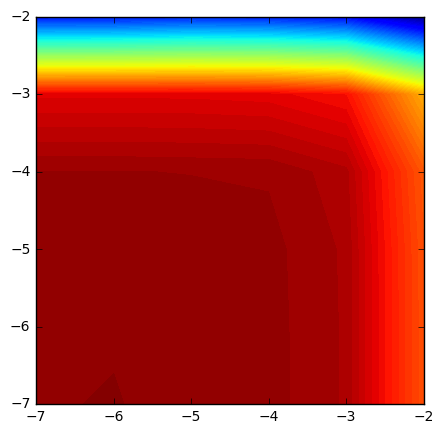

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
X = np.log10(dif_lambda)
Y = np.log10(dif_lambda)
Z = lambda_accuracies
X, Y = np.meshgrid(X, Y)
surf = ax.contourf(X, Y, Z, 100, cmap=plt.cm.jet)

plt.show()

Мы видим, что в данном случае регуляризация не дает выигрыша в качестве обучения. При стремлении параметров к нулю качество классификатора увеличивается.

# Нейросети и бинарные функции

Посмотрим, какие бинарные функции можно реализовать с помощью модели $y = \theta(wx+b)$, где $x \in 
\{0, 1\}^2$.
1. AND. Пусть $w = (1, 1), b = -1.5$. Тогда
$$\begin{cases} \theta(w(0,0)+b) = \theta(-1.5) = 0 \\
\theta(w(0,1)+b) = \theta(-0.5) = 0 \\
\theta(w(1,0)+b) = \theta(-0.5) = 0 \\
\theta(w(1,1)+b) = \theta(0.5) = 1 \end{cases}$$
2. OR. Пусть $w = (1, 1), b = -0.5$. Тогда
$$\begin{cases} \theta(w(0,0)+b) = \theta(-0.5) = 0 \\
\theta(w(0,1)+b) = \theta(0.5) = 1 \\
\theta(w(1,0)+b) = \theta(0.5) = 1 \\
\theta(w(1,1)+b) = \theta(1.5) = 1 \end{cases}$$
3. NOT Пусть $w = 1, b = -0.5$. Тогда
$$\begin{cases} \theta(w0+b) = \theta(-0.5) = 0 \\
\theta(x1+b) = \theta(0.5) = 1 \end{cases}$$

Однако некоторые бинарные функции уже от двух переменных реализовать не получится. Рассмотрим функцию $XOR$. Допустим, она реализуется с помощью данной модели. Пусть в этой реализации $w = (w_1, w_2), b = b$. Тогда подставим все возможные значения $x$:
$$\begin{cases} \theta(w(0,0)+b) = 0 \Leftrightarrow b < 0 \\
\theta(w(1,1)+b) = 0 \Leftrightarrow w_1 + w_2 + b < 0 \\
\theta(w(1,0)+b) = 0 \Leftrightarrow w_1 + b \geqslant 0 \\
\theta(w(0,1)+b) = 0 \Leftrightarrow w_2 + b \geqslant 0 \\
\end{cases}$$

Сложим первые два неравенства и последние два:
$$\begin{cases} w_1 + w_2 + 2b < 0 \\ w_1 + w_2 + 2b \geqslant 0\end{cases}$$
Получаем противоречие. Т.е. данная функция не реализуется рассматриваемой моделью.

Пусть теперь $y = \theta(w_2\theta(W_1x+b)+b).$ И будем рассматривать уже бинарные функции от $n$ переменных. Заметим, что любую функцию от $n$ переменных можно представить в виде ДНФ. Для начала покажем, что с помощью функции $\theta(wx+b)$ можно реализовать любой конъюнкт.

Действительно, пусть конъюнкт равен $x_1 \wedge \ldots \wedge x_n$. Тогда положим $w = (1, \ldots, 1), b = n - 0.5$. Все другие конъюнкты получаются поворотом пространства и линейным сдвигом. Пусть $W_1$ состоит из строк $w$, где каждая строка отвечает за конкретный конъюнкт. Тогда размер $W_1$ - $d \times n$, где $d$ - число конъюнктов. Аналогично выбирается вектор $b_1$. Получаем на выходе вектор размера $d \times 1$. Теперь к нему применяем дизъюнкцию, которая реализуется одним вектором аналогично. В итоге, мы можем реализовать любую бинарную функцию в такой модели. Значит, функция $XOR$ также реализуема.

# KERAS и нейросети

Рассмотрим нейросеть со следующей архитектурой:
$$\left[Input\right] \xrightarrow{Dense} \left[Hidden \xrightarrow{Relu} Activated\right] \xrightarrow{Dense(10)} \left[Output \xrightarrow{SoftMax} Probabilities\right].$$ Посмотрим, как качество классификации зависит от размера скрытого слоя. Будем перебирать следующие размеры: $32, 64, 128, 256, 512, 1024$.

In [46]:
from __future__ import print_function
np.random.seed(1337)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adadelta, RMSprop
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 20
accuracies = []
for i in range(5, 11):
    x2_size = 2 ** i

    model = Sequential()
    model.add(Dense(x2_size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    Y_test = np_utils.to_categorical(Y_val, nb_classes)
    X_test = X_val

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Hidden layer size:', x2_size)
    accuracies.append(history.history['val_acc'])

Hidden layer size: 32
Hidden layer size: 64
Hidden layer size: 128
Hidden layer size: 256
Hidden layer size: 512
Hidden layer size: 1024


Построим графики зависимости качества обучения от размера скрытого слоя.

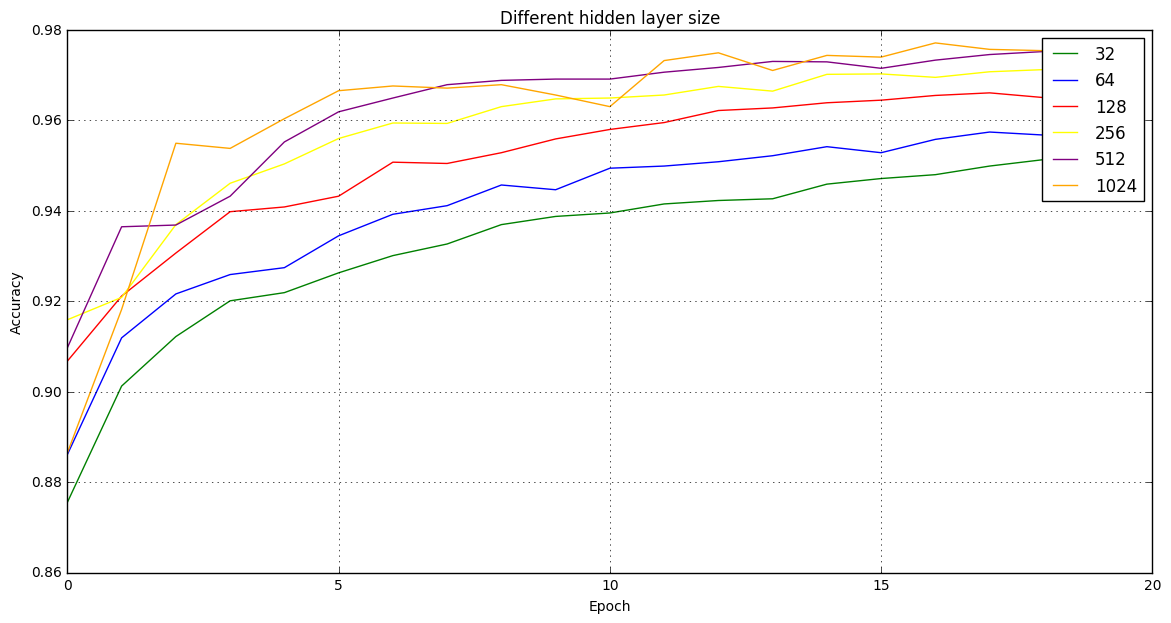

In [48]:
fig, ax = plt.subplots(figsize=(14,7))
ax.grid(True)

plt.plot(range(nb_epoch), accuracies[0], c='green', label='32')
plt.plot(range(nb_epoch), accuracies[1], c='blue', label='64')
plt.plot(range(nb_epoch), accuracies[2], c='red', label='128')
plt.plot(range(nb_epoch), accuracies[3], c='yellow', label='256')
plt.plot(range(nb_epoch), accuracies[4], c='purple', label='512')
plt.plot(range(nb_epoch), accuracies[5], c='orange', label='1024')
plt.title('Different hidden layer size')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Видно, что чем больше размер скрытого слоя, тем лучше качество классификации на отложенной выборке. Однако при размере $1024$ улучшения уже не наблюдается. Теперь фиксируем размер скрытых слоев. Рассмотрим ту же самую архитектуру и будем перебирать количество скрытых слоев: от $2$ до $6$.

In [71]:
batch_size = 128
nb_classes = 10
nb_epoch = 10
accuracies = []

for layers_number in range(1, 6):
    model = Sequential()
    model.add(Dense(256, input_shape=(784,)))
    model.add(Activation('relu'))
    for i in range(layers_number):
        model.add(Dense(256))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    Y_test = np_utils.to_categorical(Y_val, nb_classes)
    X_test = X_val

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Hidden layers number:', layers_number + 1, 'Validation accuracy:', score[1])
    accuracies.append(history.history['val_acc'])

Hidden layers number: 2 Validation accuracy: 0.970380952381
Hidden layers number: 3 Validation accuracy: 0.970571428571
Hidden layers number: 4 Validation accuracy: 0.970285714286
Hidden layers number: 5 Validation accuracy: 0.975047619048
Hidden layers number: 6 Validation accuracy: 0.95819047619


Построим графики зависимости качества обучения от количества скрытых слоев.

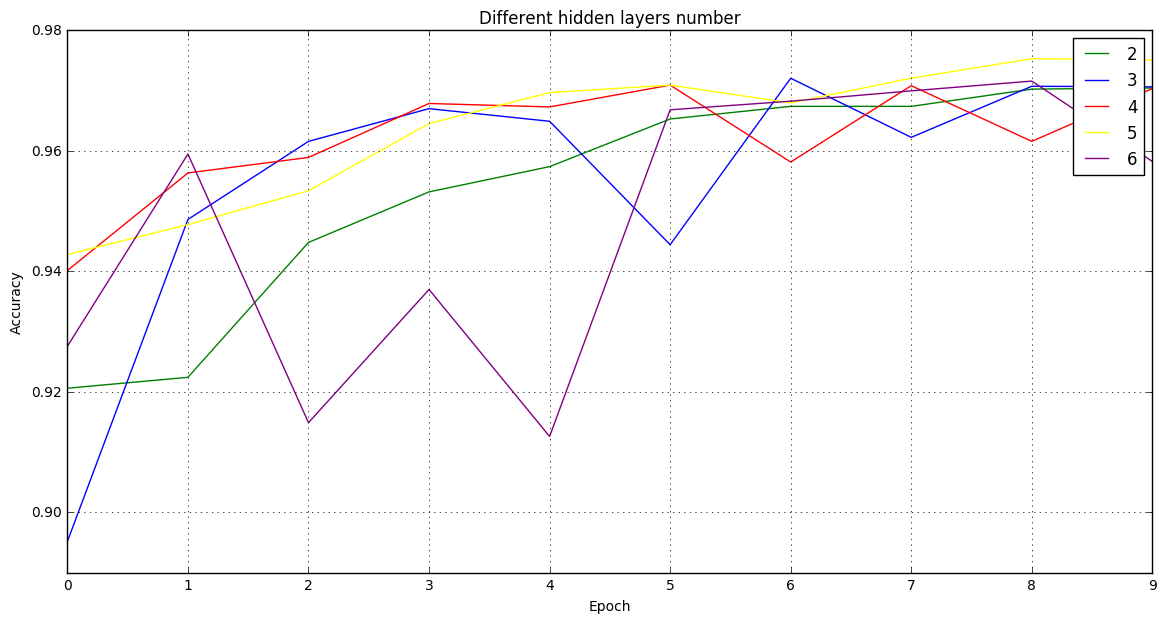

In [77]:
fig, ax = plt.subplots(figsize=(14,7))
ax.grid(True)
nb_epoch = 10

plt.plot(range(nb_epoch), accuracies[0], c='green', label='2')
plt.plot(range(nb_epoch), accuracies[1], c='blue', label='3')
plt.plot(range(nb_epoch), accuracies[2], c='red', label='4')
plt.plot(range(nb_epoch), accuracies[3], c='yellow', label='5')
plt.plot(range(nb_epoch), accuracies[4], c='purple', label='6')
plt.title('Different hidden layers number')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Как видно, итоговое качество получается достаточно хорошим при разном количестве слоев, однако оптимальный результат достигается при 5 слоях - дальше результат резко падает, т.к. происходит переобучение.

In [67]:
batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_259 (Dense)                (None, 512)           401920      dense_input_74[0][0]             
____________________________________________________________________________________________________
activation_259 (Activation)      (None, 512)           0           dense_259[0][0]                  
____________________________________________________________________________________________________
dropout_20 (Dropout)             (None, 512)           0           activation_259[0][0]             
____________________________________________________________________________________________________
dense_260 (Dense)                (None, 512)           262656      dropout_20[0][0]                 
___________________________________________________________________________________________

Данная конфигурация дает $98.12\%$ правильных ответов на отложенной выборке. Попробуем немного изменить архитектуру нейросети:

In [150]:
batch_size = 128
nb_classes = 10
nb_epoch = 50

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('softsign'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 31500 samples, validate on 10500 samples
Epoch 1/50
31500/31500 [==============================] - 13s - loss: 0.4405 - acc: 0.8730 - val_loss: 0.3241 - val_acc: 0.8946
Epoch 2/50
31500/31500 [==============================] - 10s - loss: 0.1747 - acc: 0.9488 - val_loss: 0.1689 - val_acc: 0.9464
Epoch 3/50
31500/31500 [==============================] - 10s - loss: 0.1222 - acc: 0.9634 - val_loss: 0.1160 - val_acc: 0.9646
Epoch 4/50
31500/31500 [==============================] - 10s - loss: 0.0927 - acc: 0.9726 - val_loss: 0.0997 - val_acc: 0.9682
Epoch 5/50
31500/31500 [==============================] - 10s - loss: 0.0714 - acc: 0.9786 - val_loss: 0.0926 - val_acc: 0.9708
Epoch 6/50
31500/31500 [==============================] - 10s - loss: 0.0585 - acc: 0.9822 - val_loss: 0.0840 - val_acc: 0.9745
Epoch 7/50
31500/31500 [==============================] - 10s - loss: 0.0458 - acc: 0.9863 - val_loss: 0.0860 - val_acc: 0.9736
Epoch 8/50
31500/31500 [==============================

Как видно, качество улучшилось за счет добавления нового слоя. Однако, это требует большего количества проходов по данным.